In [1]:
!pip install torch torchvision datasets
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-aottgkga
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-aottgkga
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=a2b3b1abb7068aca16a89735504db92b289628a2fb5727b0dd8d202ca0c06d4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-72eybj_8/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
from datasets import load_dataset
import clip
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device = device, jit=False)

100%|████████████████████████████████████████| 335M/335M [00:03<00:00, 108MiB/s]


In [4]:
ds = load_dataset("aggr8/brain_mri_train_test_split")

Generating train split:   0%|          | 0/480 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

In [5]:
text_prompts = ["a photo of glioma tumor", "a photo of meningioma tumor", "a photo of no tumor", "a photo of pituitary tumor"]

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = preprocess(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


class CustomImageDatasetTrain(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = clip.tokenize([text_prompts[label] for label in labels])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = preprocess(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transformations = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])



In [6]:
dataset = CustomImageDatasetTrain(ds["train"]["image"], ds["train"]["label"], transform=transformations)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(ds["test"]["image"], ds["test"]["label"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_dataset_2 = CustomImageDataset(ds["train"]["image"], ds["train"]["label"])
test_dataloader_2 = DataLoader(test_dataset_2, batch_size=32, shuffle=False)

In [7]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [8]:
model_ft = CLIPFineTuner(model, 4).to(device)

for param in model_ft.model.parameters():
  param.requires_grad = False


for param in model_ft.classifier.parameters():
  param.requires_grad = True


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.classifier.parameters(), lr=1e-2)

In [10]:
from tqdm import tqdm
import torch
import os

# Number of epochs for training
num_epochs = 25

best_accuracy = 0

best_model_path = "/kaggle/working/linear_head_finetune_best_model_3.pth"

train_acc = []
test_acc = []
epoches = []
train_loss = []
test_loss = []
prev_train_acc = prev_test_acc = prev_train_loss = prev_test_loss = None

# Training loop
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model

        # Update pred_label and true_label
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        pred_label.extend(predicted.cpu().numpy())  # Store predictions
        true_label.extend(labels.cpu().numpy())  # Store true labels

        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}")  # Update progress bar with current loss

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 1)
    train_loss.append(running_loss/len(test_dataloader_2))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter
    running_loss_test = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions
            loss = criterion(outputs, labels)  # Calculate the loss
            running_loss_test += loss.item()  # Update running loss

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)
    test_loss.append(running_loss_test/len(test_dataloader))

    print(f'Validation Accuracy: {accuracy_test:.2f}%')  # Print validation accuracy for the epoch

    # Calculate convergence speed
    if prev_train_acc is not None:
        acc_conv_speed_train = train_accuracy - prev_train_acc
        acc_conv_speed_test = accuracy_test - prev_test_acc
        loss_conv_speed_train = prev_train_loss - train_loss[-1]
        loss_conv_speed_test = prev_test_loss - test_loss[-1]

        print(f'Convergence Speed - Training Accuracy: {acc_conv_speed_train:.4f}, Validation Accuracy: {acc_conv_speed_test:.4f}')
        print(f'Convergence Speed - Training Loss: {loss_conv_speed_train:.4f}, Validation Loss: {loss_conv_speed_test:.4f}')

    # Update previous epoch values
    prev_train_acc, prev_test_acc = train_accuracy, accuracy_test
    prev_train_loss, prev_test_loss = train_loss[-1], test_loss[-1]

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/kaggle/working/", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

# Optionally, you can visualize the accuracy over epochs



Epoch 1/25, Loss: 1.2133: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch [1/25], Loss: 1.2133, Training Accuracy: 43.96%
Validation Accuracy: 56.88%
Best model saved with accuracy 56.88%


Epoch 2/25, Loss: 0.7620: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


Epoch [2/25], Loss: 0.7620, Training Accuracy: 73.12%
Validation Accuracy: 75.31%
Convergence Speed - Training Accuracy: 29.1667, Validation Accuracy: 18.4375
Convergence Speed - Training Loss: 0.4512, Validation Loss: 0.2631
Best model saved with accuracy 75.31%


Epoch 3/25, Loss: 0.6129: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


Epoch [3/25], Loss: 0.6129, Training Accuracy: 79.17%
Validation Accuracy: 83.75%
Convergence Speed - Training Accuracy: 6.0417, Validation Accuracy: 8.4375
Convergence Speed - Training Loss: 0.1492, Validation Loss: 0.1648
Best model saved with accuracy 83.75%


Epoch 4/25, Loss: 0.5073: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


Epoch [4/25], Loss: 0.5073, Training Accuracy: 84.38%
Validation Accuracy: 85.31%
Convergence Speed - Training Accuracy: 5.2083, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: 0.1056, Validation Loss: 0.0622
Best model saved with accuracy 85.31%


Epoch 5/25, Loss: 0.4418: 100%|██████████| 15/15 [00:03<00:00,  4.90it/s]


Epoch [5/25], Loss: 0.4418, Training Accuracy: 87.29%
Validation Accuracy: 85.31%
Convergence Speed - Training Accuracy: 2.9167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0655, Validation Loss: 0.0300


Epoch 6/25, Loss: 0.4011: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


Epoch [6/25], Loss: 0.4011, Training Accuracy: 87.92%
Validation Accuracy: 85.31%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0406, Validation Loss: 0.0229


Epoch 7/25, Loss: 0.3701: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch [7/25], Loss: 0.3701, Training Accuracy: 89.58%
Validation Accuracy: 86.56%
Convergence Speed - Training Accuracy: 1.6667, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: 0.0310, Validation Loss: 0.0211
Best model saved with accuracy 86.56%


Epoch 8/25, Loss: 0.3434: 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


Epoch [8/25], Loss: 0.3434, Training Accuracy: 90.21%
Validation Accuracy: 86.56%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0267, Validation Loss: 0.0173


Epoch 9/25, Loss: 0.3208: 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]


Epoch [9/25], Loss: 0.3208, Training Accuracy: 90.42%
Validation Accuracy: 86.88%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0227, Validation Loss: 0.0138
Best model saved with accuracy 86.88%


Epoch 10/25, Loss: 0.3019: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


Epoch [10/25], Loss: 0.3019, Training Accuracy: 91.04%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0189, Validation Loss: 0.0112
Best model saved with accuracy 87.81%


Epoch 11/25, Loss: 0.2860: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


Epoch [11/25], Loss: 0.2860, Training Accuracy: 91.25%
Validation Accuracy: 88.12%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0159, Validation Loss: 0.0095
Best model saved with accuracy 88.12%


Epoch 12/25, Loss: 0.2722: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch [12/25], Loss: 0.2722, Training Accuracy: 91.46%
Validation Accuracy: 88.75%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0138, Validation Loss: 0.0084
Best model saved with accuracy 88.75%


Epoch 13/25, Loss: 0.2600: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch [13/25], Loss: 0.2600, Training Accuracy: 92.29%
Validation Accuracy: 89.38%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0122, Validation Loss: 0.0071
Best model saved with accuracy 89.38%


Epoch 14/25, Loss: 0.2491: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


Epoch [14/25], Loss: 0.2491, Training Accuracy: 93.12%
Validation Accuracy: 89.06%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0109, Validation Loss: 0.0055


Epoch 15/25, Loss: 0.2391: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch [15/25], Loss: 0.2391, Training Accuracy: 93.12%
Validation Accuracy: 90.00%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0100, Validation Loss: 0.0034
Best model saved with accuracy 90.00%


Epoch 16/25, Loss: 0.2298: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]


Epoch [16/25], Loss: 0.2298, Training Accuracy: 93.54%
Validation Accuracy: 90.00%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0094, Validation Loss: 0.0008


Epoch 17/25, Loss: 0.2208: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Epoch [17/25], Loss: 0.2208, Training Accuracy: 93.75%
Validation Accuracy: 89.69%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0090, Validation Loss: -0.0019


Epoch 18/25, Loss: 0.2121: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


Epoch [18/25], Loss: 0.2121, Training Accuracy: 93.75%
Validation Accuracy: 89.69%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0087, Validation Loss: -0.0041


Epoch 19/25, Loss: 0.2038: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


Epoch [19/25], Loss: 0.2038, Training Accuracy: 94.17%
Validation Accuracy: 88.75%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: 0.0083, Validation Loss: -0.0053


Epoch 20/25, Loss: 0.1960: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Epoch [20/25], Loss: 0.1960, Training Accuracy: 94.38%
Validation Accuracy: 88.75%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0078, Validation Loss: -0.0051


Epoch 21/25, Loss: 0.1886: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]


Epoch [21/25], Loss: 0.1886, Training Accuracy: 94.79%
Validation Accuracy: 88.44%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0073, Validation Loss: -0.0041


Epoch 22/25, Loss: 0.1818: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]


Epoch [22/25], Loss: 0.1818, Training Accuracy: 95.21%
Validation Accuracy: 88.12%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0069, Validation Loss: -0.0028


Epoch 23/25, Loss: 0.1754: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch [23/25], Loss: 0.1754, Training Accuracy: 95.62%
Validation Accuracy: 88.12%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0064, Validation Loss: -0.0017


Epoch 24/25, Loss: 0.1695: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


Epoch [24/25], Loss: 0.1695, Training Accuracy: 96.04%
Validation Accuracy: 88.12%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0059, Validation Loss: -0.0012


Epoch 25/25, Loss: 0.1640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch [25/25], Loss: 0.1640, Training Accuracy: 96.88%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0055, Validation Loss: -0.0011


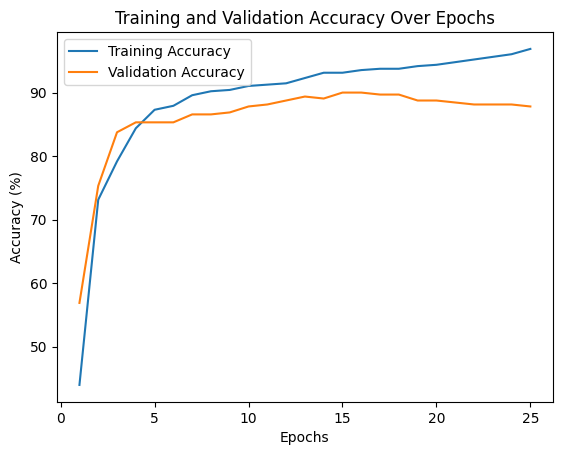

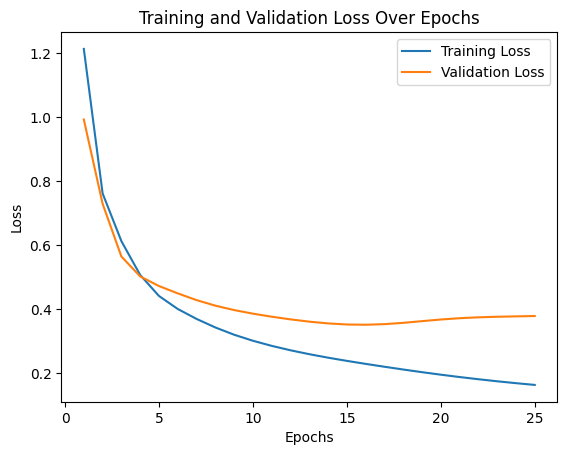

In [11]:
import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()